# Rag From Scratch: Overview

These notebooks walk through the process of building RAG app(s) from scratch.

They will build towards a broader understanding of the RAG langscape, as shown here:

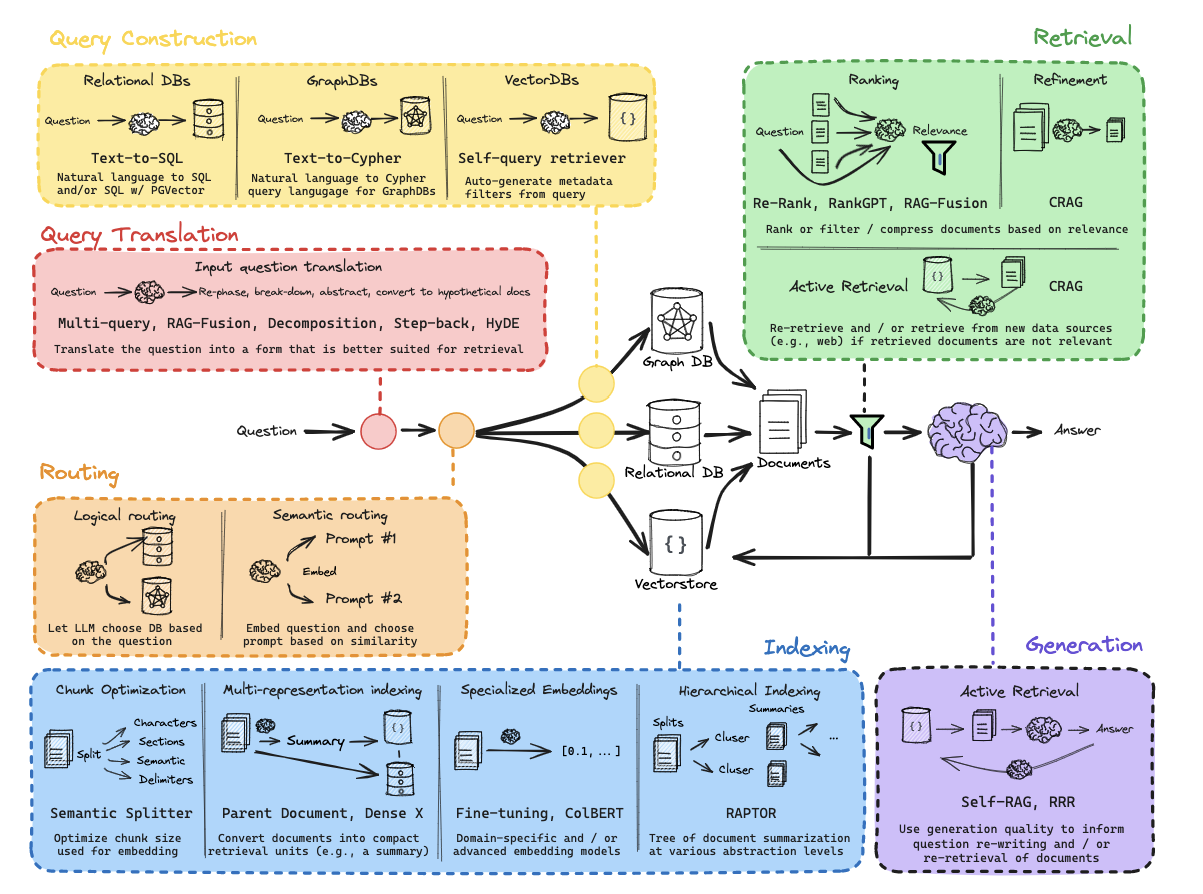

## Enviornment

`(1) Packages`

In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
Using cached urllib3-2.2.1-py3-none-any.whl (121 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.27.28 requires urllib3<1.27,>=1.25.4, but you have urllib3 2.2.1 which is incompatible.
llama-index 0.7.8 requires urllib3<2, but you have urllib3 2.2.1 which is incompatible.


`(2) LangSmith`

https://docs.smith.langchain.com/

In [3]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = "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"

`(3) API Keys`

In [4]:
os.environ['OPENAI_API_KEY'] = ''

## Part 1: Overview
 
[RAG quickstart](https://python.langchain.com/docs/use_cases/question_answering/quickstart)

In [5]:
# Import library
"""
•	bs4: This is Beautiful Soup, a library used for parsing HTML and XML documents.
•	langchain: A framework for building language model applications.
•	langchain_community.document_loaders: Contains community-contributed document loaders.
•	langchain_community.vectorstores: Contains community-contributed vector stores.
•	langchain_core.output_parsers: Contains core output parsers.
•	langchain_core.runnables: Contains core runnables (a runnable is a component that can perform some computation).
•	langchain_openai: Provides access to OpenAI language models and embeddings.
"""
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

## Indexing

In [6]:
# Load Documents
"""
•	bs_kwargs: Arguments passed to Beautiful Soup to filter specific parts of the HTML.
•	parse_only: Filters only elements with the specified classes.
•	loader.load(): Loads the document from the web.
"""
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [7]:
# Extract content from the documents
content = "\n\n".join(doc.page_content for doc in docs)

# Save content to a text file
with open("documents.txt", "w", encoding="utf-8") as f:
    f.write(content)

print("Documents saved to documents.txt")

Documents saved to documents.txt


In [8]:
# Split
"""
•	RecursiveCharacterTextSplitter: Splits text into chunks.
•	chunk_size: Maximum size of each chunk.
•	chunk_overlap: Number of overlapping characters between chunks.
•	split_documents: Splits the loaded document into chunks.
"""
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [9]:
# Embed
"""
•	Chroma: A vector store that can store document embeddings.
•	from_documents: Creates a vector store from the provided documents.
•	OpenAIEmbeddings: Generates embeddings using OpenAI’s model.
"""
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

# 	as_retriever: Converts the vector store into a retriever that can be used to retrieve relevant documents.
retriever = vectorstore.as_retriever()

In [10]:
type(retriever)

langchain_core.vectorstores.VectorStoreRetriever

In [15]:
print(retriever)

tags=['Chroma', 'OpenAIEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f7b5116ad30>


In [13]:
#### VIEWING THE OUTPUT OF THE RETRIEVER ####

# Define a query
query = "What is Task Decomposition?"

# Retrieve documents relevant to the query
retrieved_docs = retriever.get_relevant_documents(query)

# Print the retrieved documents
for i, doc in enumerate(retrieved_docs, 1):
    print(f"Document {i}:")
    print(doc.page_content)
    print("\n" + "="*80 + "\n")

/Users/NapoleonChow/opt/anaconda3/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Document 1:
Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.


Document 2:
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a p

In [14]:
#### RETRIEVAL and GENERATION ####
"""
•	hub.pull: Pulls a pre-defined prompt from LangChain Hub.
{
    "input_variables": ["context", "question"],
    "template": "You are an expert in {context}. Answer the following question: {question}",
    "instructions": "Fill in the placeholders with the appropriate context and question."
}
•	ChatOpenAI: Initializes the OpenAI GPT-3.5 Turbo language model.
•	model_name: Specifies the model to use.
•	temperature: Controls the randomness of the model’s output (0 means deterministic).
•	format_docs: Function to format retrieved documents by concatenating their content.
•	rag_chain: Defines a chain for retrieval-augmented generation (RAG).
•	context: The retriever and document formatter.
•	question: The question input.
•	RunnablePassthrough: Passes the input through without modification.
•	prompt: The pre-defined prompt.
•	llm: The language model.
•	StrOutputParser: Parses the output into a string format.
•	invoke: Runs the chain with the given question.
"""

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is a technique used to break down complex tasks into smaller and simpler steps. This approach helps agents to plan and execute tasks more efficiently by dividing them into manageable subgoals. Task decomposition can be achieved through various methods such as prompting with specific instructions or utilizing human inputs.'

## Part 2: Indexing

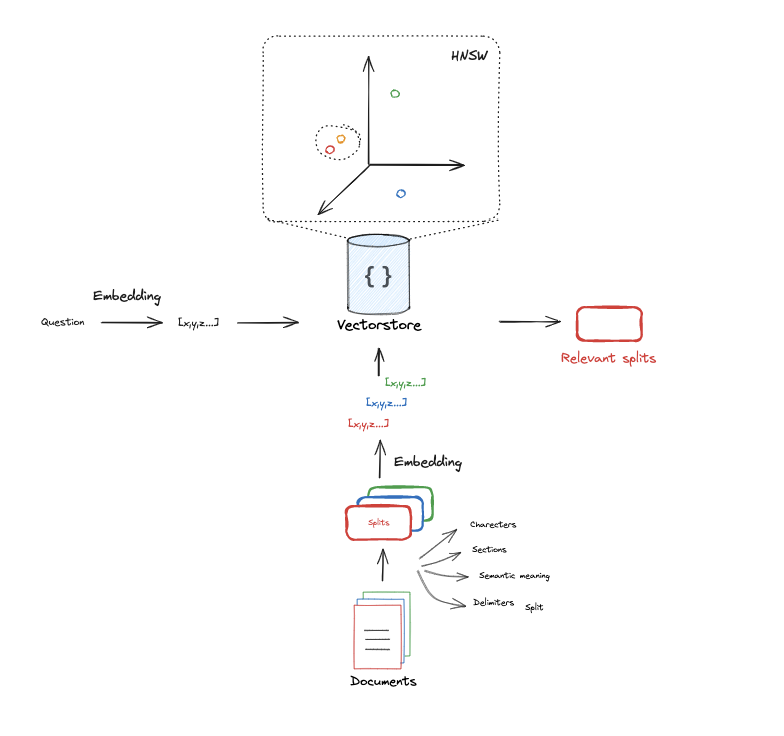

In [53]:
# Documents
question = "What kinds of pets do I hate?"
document = "My favorite pet is a cat."

[Count tokens](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb) considering [~4 char / token](https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them)

In [54]:
# tiktoken: a library used for tokenizing text
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

8

#### Remark:
|Encoding name      |OpenAI models|
|-------------------|-------------|
|o200k_base         |gpt-4o-       |
|cl100k_base        |gpt-4, gpt-3.5-turbo, text-embedding-ada-002, text-embedding-3-small, text-embedding-3-large|
p50k_base           |Codex models, text-davinci-002, text-davinci-003|
r50k_base (or gpt2) |	GPT-3 models like davinci|

Reference: https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken

Reference: https://github.com/openai/tiktoken/tree/main

In [56]:
import tiktoken

# Define the text to be tokenized
text = "What kinds of pets do I like?"

# Get the tokenizer for the specific encoding (e.g., 'cl100k_base')
encoding = tiktoken.get_encoding('cl100k_base')

# Assuming tiktoken provides a method to get the token for a given ID
tokens = encoding.encode(text)
token_words = [encoding.decode([token]) for token in tokens]

# Print token IDs and corresponding words
for token, word in zip(tokens, token_words):
    print(f"Token ID: {token}, Token Word: {word}")

Token ID: 3923, Token Word: What
Token ID: 13124, Token Word:  kinds
Token ID: 315, Token Word:  of
Token ID: 26159, Token Word:  pets
Token ID: 656, Token Word:  do
Token ID: 358, Token Word:  I
Token ID: 1093, Token Word:  like
Token ID: 30, Token Word: ?


[Text embedding models](https://python.langchain.com/docs/integrations/text_embedding/openai)

In [34]:
from langchain_openai import OpenAIEmbeddings
# This initializes an instance of the OpenAIEmbeddings class. The instance embd can now be used to generate embeddings for text.
embd = OpenAIEmbeddings()
# This uses the embed_query method to generate an embedding for the question text. The resulting embedding is stored in the query_result variable.
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
print(f"the length of query_result is {len(query_result)} and the length of document_result is {len(document_result)}")

the length of query_result is 1536 and the length of document_result is 1536


In [35]:
print(query_result)

[-0.006671291063002228, -0.006857675724637037, -0.007731756448453917, -0.01797006710567633, -0.028047702261777552, 0.006343510675155572, -0.0041326011020836675, 0.005144863557802215, -0.018805584554384094, -0.003544525126508706, 0.0021964486941519635, 0.002932347220405872, -0.011568712449179688, -0.003070529185138192, 0.005752220938101084, 0.02299602963780883, 0.03576017660701561, 0.016646091439694206, 0.030001527680294165, -0.007635350588987636, -0.027482119356930162, 0.013753913793060586, -0.007333278430331989, -0.008355181006335862, -0.003560592769753086, -0.0037534044886856468, 0.019114085167321403, -0.014820806235810027, -0.01028972711560443, -0.02043805897065832, 0.026402373730907824, -0.022918904950235807, -0.03370351827173496, 7.491545211054266e-05, -0.007044060851933148, 0.0033549267033943704, 0.016170489199660555, -0.004685328495351643, 0.02216051218910107, -0.007275434914652221, 0.006709853406788741, 0.004267569770997762, 0.015823428105581946, 0.009505625193956079, 0.0132397

[Cosine similarity](https://platform.openai.com/docs/guides/embeddings/frequently-asked-questions) is reccomended (1 indicates identical) for OpenAI embeddings.

In [36]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)
# I have changed the question to what I hate instead of what I like, but the cosine similarity is changed from 0.88 to 0.82, not a good evaluation.

Cosine Similarity: 0.825610941070544


[Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/)

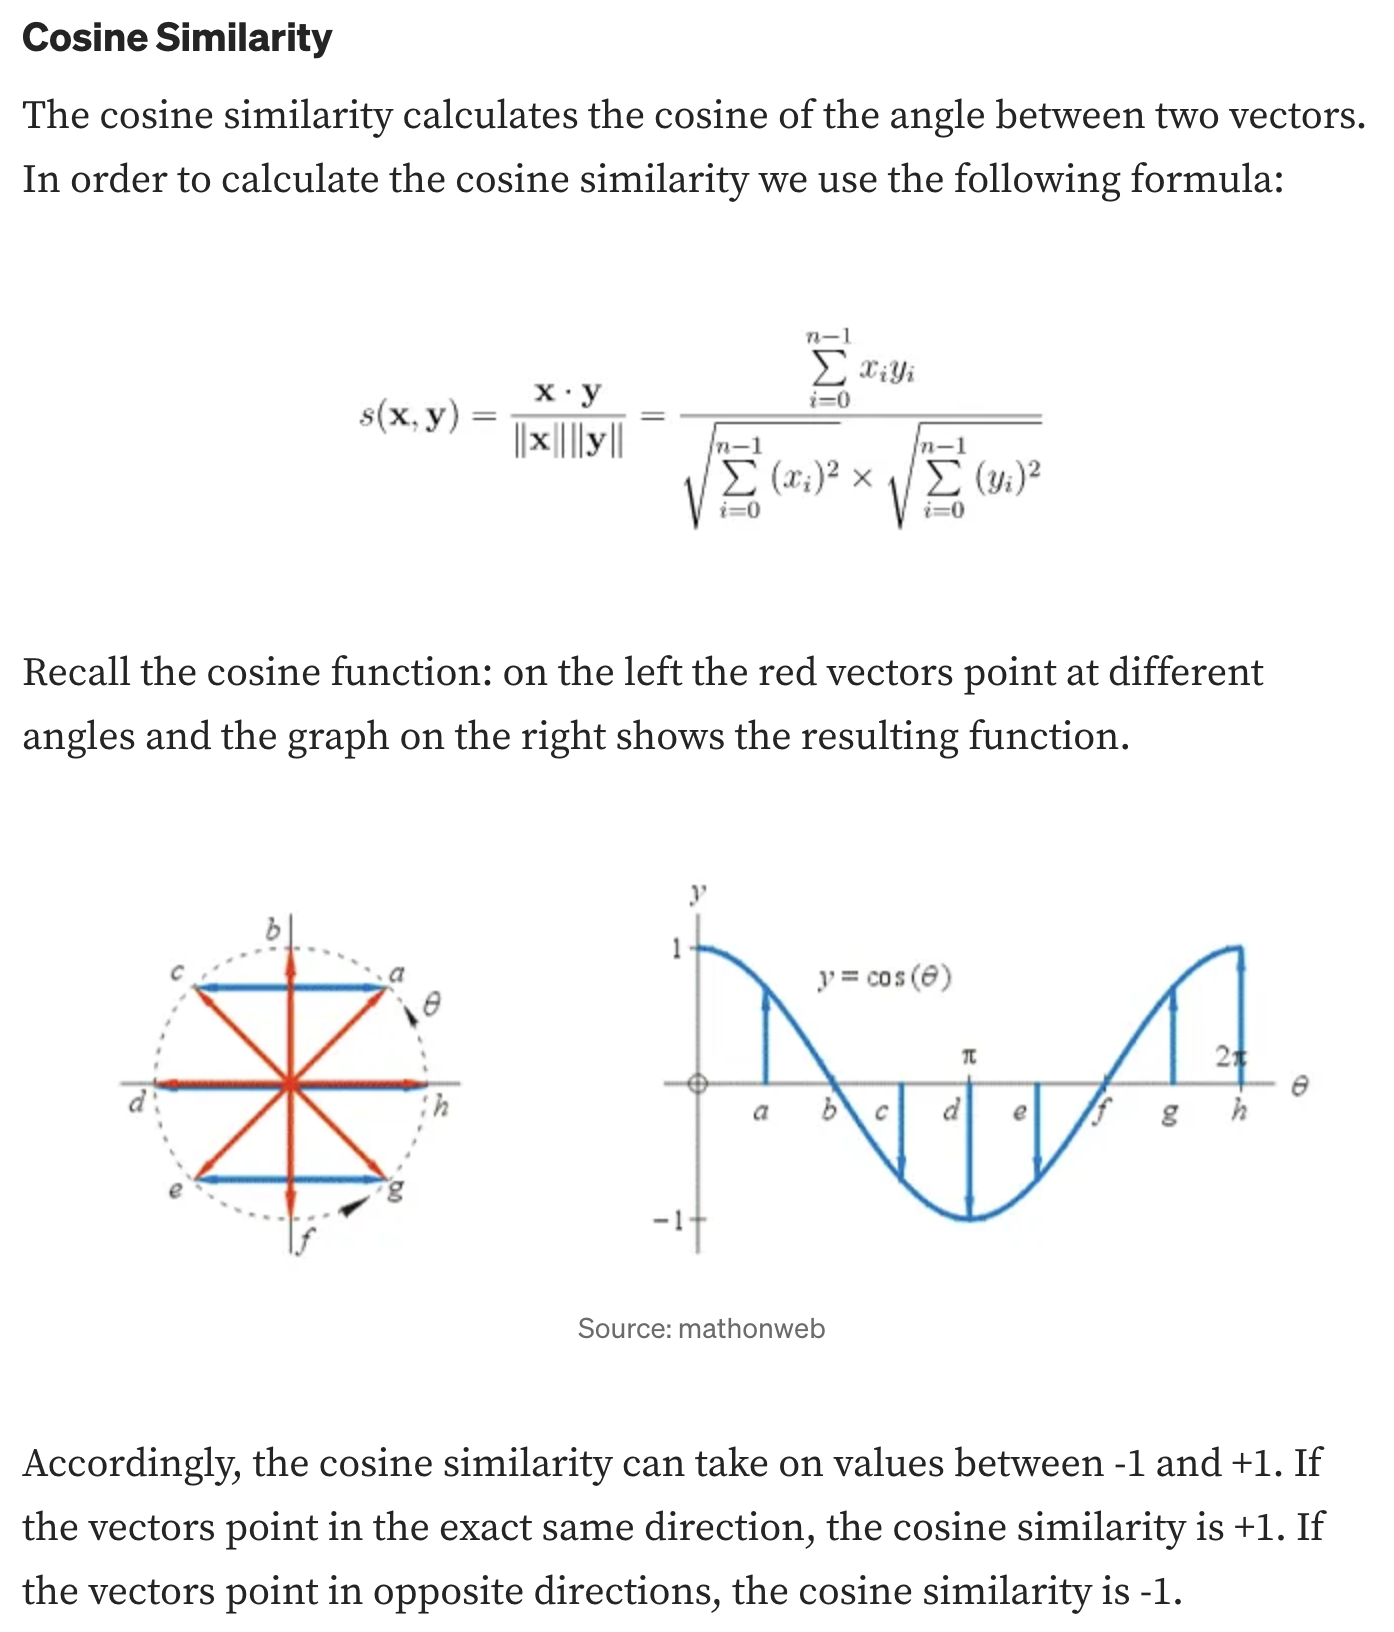

In [37]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

[Splitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter)

> This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [38]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

[Vectorstores](https://python.langchain.com/docs/integrations/vectorstores/)

In [39]:
# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

## Part 3: Retrieval

In [40]:
# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

# 	Converts the vector store into a retriever. The search_kwargs={"k": 1} argument specifies that the retriever should return the top 1 most relevant document.
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [41]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

In [42]:
len(docs)

1

In [45]:
for i, doc in enumerate(docs, 1):
    print(f"Document {i}:")
    print(doc.page_content)
    print("\n" + "="*80 + "\n")

Document 1:
Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majo

## Part 4: Generation

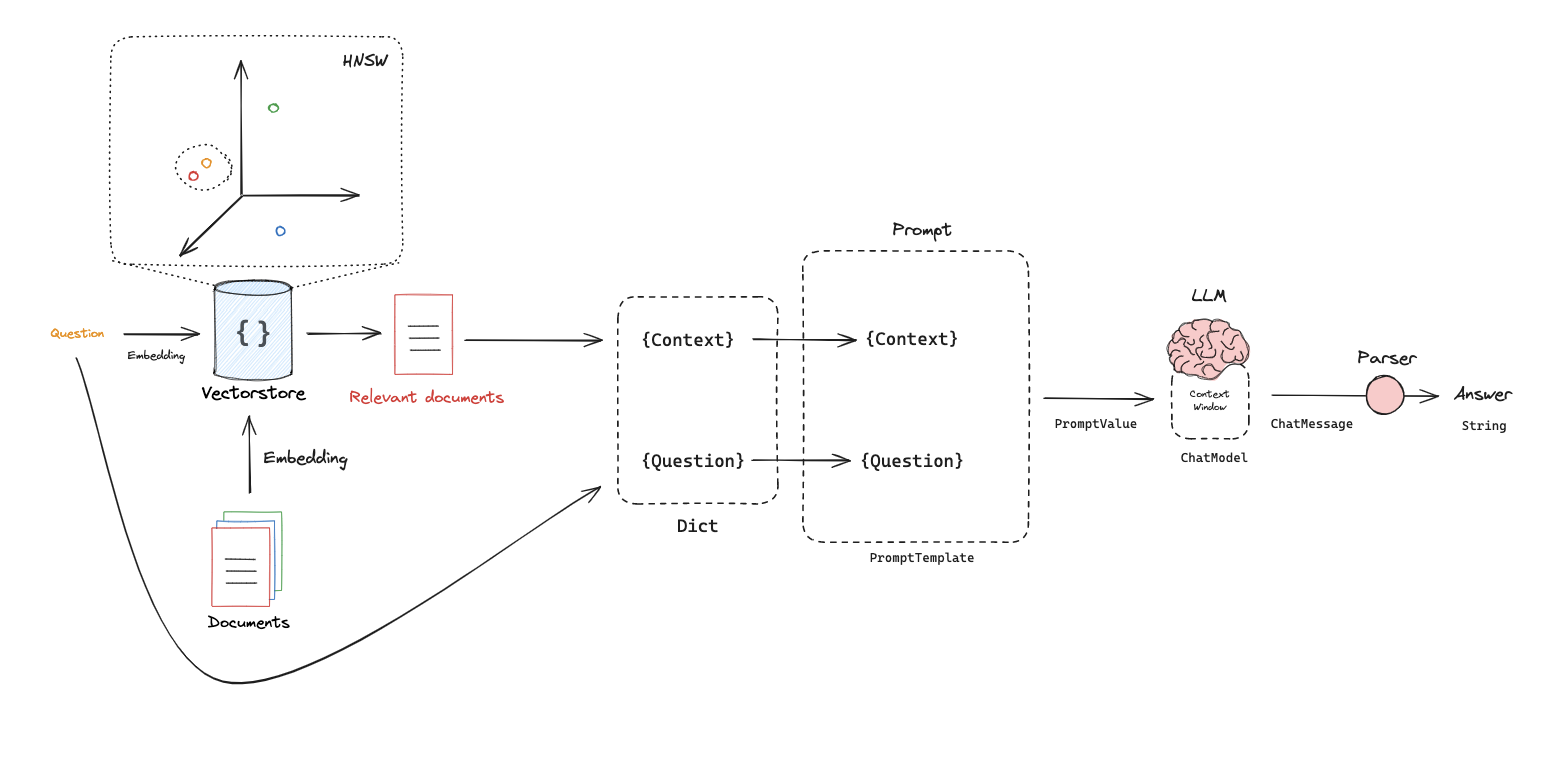

In [46]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'))])

In [47]:
# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [48]:
# Chain
chain = prompt | llm

In [49]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

AIMessage(content='Task Decomposition is the process of breaking down a complex task into smaller and simpler steps, making it more manageable for an autonomous agent to plan and execute. This can be achieved through techniques like Chain of Thought and Tree of Thoughts, which prompt the agent to think step by step and explore multiple reasoning possibilities at each step. Task decomposition can also be facilitated through simple prompting, task-specific instructions, or human inputs.', response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 331, 'total_tokens': 413}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-f19f3429-2d54-4d7e-8519-56fab7e42438-0')

In [50]:
# The hub is a central repository or collection within the langchain framework where predefined components, templates, or configurations are stored.
# allows users to easily access and reuse these components without needing to define them from scratch.
from langchain import hub
# hub.pull() is a method used to retrieve predefined components (like prompts, models, or chains) from a central repository (the hub).
"""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""
prompt_hub_rag = hub.pull("rlm/rag-prompt")

rlm/rag-prompt

Reference: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=7582ae98-3851-5f7e-aa44-d8ab3c83a49e

In [51]:
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

[RAG chains](https://python.langchain.com/docs/expression_language/get_started#rag-search-example)

In [52]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is a technique that involves breaking down a complex task into smaller and simpler steps in order to make it more manageable for an autonomous agent system. This can be achieved through prompting techniques like Chain of Thought and Tree of Thoughts, as well as task-specific instructions or human inputs.'